# 1A - Enoncé 24 novembre 2020

Correction de l'examen du 24 novembre 2020.

## Exercice 1 : guérison

On commence par générer des données artificielles à partir de véritables données, disponible depuis le site [Données hospitalières relatives à l'épidémie de COVID-19](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/).

* *rad* : personnes retournées à domicile (cumul)
* *dc* : personnes décédées (cumul)

In [1]:
import pandas

df = pandas.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7",
    sep=";",
)
gr = df[["jour", "rad", "dc"]].groupby(["jour"]).sum()
gr.head()

,rad,dc
jour,,
2020-03-18,1627,435
2020-03-19,2322,642
2020-03-20,3128,890
2020-03-21,3580,1041
2020-03-22,4188,1251


In [2]:
diff = gr.diff().reset_index(drop=False)
diff.head()

,jour,rad,dc
0,2020-03-18,NaN,NaN
1,2020-03-19,695.0,207.0
2,2020-03-20,806.0,248.0
3,2020-03-21,452.0,151.0
4,2020-03-22,608.0,210.0


In [3]:
diff.tail()

,jour,rad,dc
1104,2023-03-27,810.0,84.0
1105,2023-03-28,966.0,77.0
1106,2023-03-29,1003.0,67.0
1107,2023-03-30,736.0,71.0
1108,2023-03-31,1008.0,61.0


Les données sont parfois erronnées et corrigées. Bien que les séries soient cumulées, la différence censée être positive peut ne pas l'être. Même s'il faudrait se pencher un peu sur le problème pour corriger les données, dans notre cas, on ne tient pas compte des valeurs négatives.

In [4]:
import numpy

diff["rad"] = numpy.maximum(diff["rad"], 0)
diff["dc"] = numpy.maximum(diff["dc"], 0)

On convertit la date en jour de l'année puis on simule un loi exponentielle de paramètre 14 pour avoir la date de sortie.

In [5]:
import numpy.random as rnd


def donnees_artificielles(hosp, mu=14, nu=21):
    dt = pandas.to_datetime(hosp["jour"])
    res = []
    for i in range(hosp.shape[0]):
        date = dt[i].dayofyear
        h = hosp.iloc[i, 1]
        try:
            delay = rnd.exponential(mu, int(h))
        except Exception as e:
            print(hosp.shape, i)
            print(hosp.iloc[i])
            print(e)
            raise e
        for j in range(delay.shape[0]):
            res.append([date - int(delay[j]), date, 1])
        h = hosp.iloc[i, 2]
        delay = rnd.exponential(nu, int(h))
        for j in range(delay.shape[0]):
            res.append([date - int(delay[j]), date, 0])
    return pandas.DataFrame(res, columns=["entree", "sortie", "issue"])


data = donnees_artificielles(diff[1:].reset_index(drop=True))
data.head()

,entree,sortie,issue
0,6,79,1
1,64,79,1
2,31,79,1
3,65,79,1
4,62,79,1


In [6]:
data.to_csv("examen2021.csv", index=False)

### Q1

On récupère les données.

In [7]:
import pandas

df = pandas.read_csv(
    "https://github.com/sdpython/teachpyx/raw/main/_data/examen2021.zip"
)
df.head()

,entree,sortie,issue
0,49,79,1
1,27,79,1
2,73,79,1
3,74,79,1
4,48,79,1


### Q2 : durée de guérison

In [8]:
duree = df["sortie"] - df["entree"]
duree = duree.values  # conversion en numpy
issue = df["issue"].values
duree[:5], issue[:5]

(array([30, 52,  6,  5, 31], dtype=int64), array([1, 1, 1, 1, 1], dtype=int64))

### Q3 : estimateur Kaplan-Meier (1)

In [9]:
t = 10
nt = duree[(duree >= t)].shape[0]
dt = duree[(duree == t) & (issue == 0)].shape[0]
st = 1.0 - dt / nt
st

0.98965342710248

### Q4 : courbe de Kaplan-Meier

In [10]:
T = [0]
St = [1.0]
for t in range(0, 150):
    nt = duree[(duree >= t)].shape[0]
    dt = duree[(duree == t) & (issue == 0)].shape[0]
    st = 1.0 - dt / nt
    T.append(t)
    St.append(st * St[-1])

### Q5 : graphe

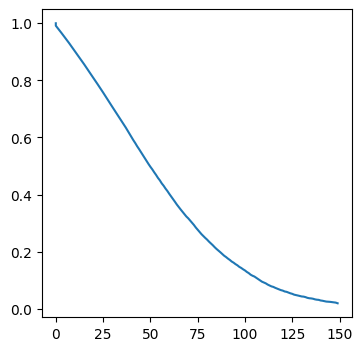

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(T, St);

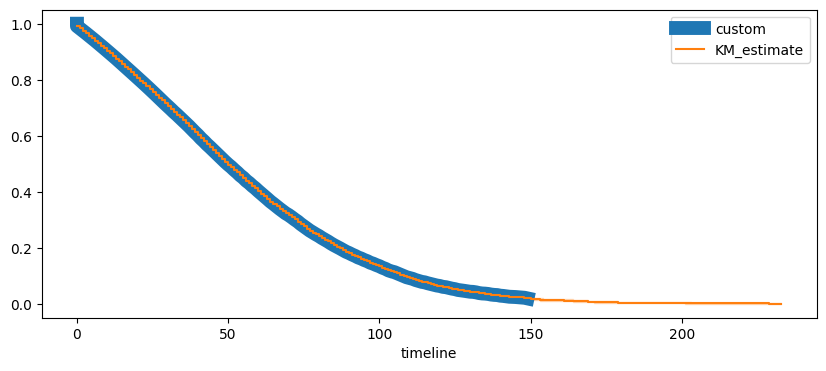

In [13]:
import numpy
from lifelines import KaplanMeierFitter

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(T, St, label="custom", lw=10)

kmf = KaplanMeierFitter()
kmf.fit(duree, (issue == 0).astype(numpy.int32))
kmf.plot(ax=ax)
ax.legend();

### Q6 : application aux données publiques

Les données accessibles librement sur le portail [data.gouv.fr](https://www.data.gouv.fr/fr/) recensent les entrées et les sorties des personnes sans relier une entrée et une sortie spécifique. Si N est personnes sont sorties guéries, on ne sait pas quand elles sont entrées. Donc le calcul ci-dessus n'est pas possible.

## Exercice 2

### Q1 : t + 1

In [14]:
import numpy

N = 10
M = numpy.zeros((N, N))
M[4, 5] = 1
M

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
def propagation(M):
    M2 = M.copy()
    M2[1:, :] = numpy.maximum(M2[1:, :], M[:-1, :])
    M2[:-1, :] = numpy.maximum(M2[:-1, :], M[1:, :])
    M2[:, 1:] = numpy.maximum(M2[:, 1:], M[:, :-1])
    M2[:, :-1] = numpy.maximum(M2[:, :-1], M[:, 1:])
    return M2


propagation(M.copy())

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Q2 : après T itération

In [16]:
def propagation_n(M, t):
    for i in range(t):
        M = propagation(M)
    return M


propagation_n(M, 3)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Q3 : vaccin

In [17]:
p = 0.3
vaccine = (numpy.random.rand(N, N) <= p).astype(numpy.int32)
vaccine

array([[0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [18]:
def propagation_vaccine(M, vaccine):
    M2 = M.copy()
    M2[1:, :] = numpy.maximum(M2[1:, :], M[:-1, :])
    M2[:-1, :] = numpy.maximum(M2[:-1, :], M[1:, :])
    M2[:, 1:] = numpy.maximum(M2[:, 1:], M[:, :-1])
    M2[:, :-1] = numpy.maximum(M2[:, :-1], M[:, 1:])
    M2 = numpy.minimum(M2, 1 - vaccine)
    return M2


vaccine[4, 5] = 0
propagation_vaccine(M, vaccine)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Q4 : après T heures

In [19]:
def propagation_n_vaccine(M, t, vaccine):
    for i in range(t):
        M = propagation_vaccine(M, vaccine)
    return M


propagation_n_vaccine(M, 3, vaccine)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Q5 : variation

In [20]:
import pandas

res = []
for p in [
    0.7,
    0.8,
    0.85,
    0.86,
    0.87,
    0.88,
    0.89,
    0.9,
    0.94,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1.0,
]:
    cont = []
    for test in range(0, 10):
        vaccine = (numpy.random.rand(N, N) <= p).astype(numpy.int32)
        M[4, 5] = 1
        vaccine[4, 5] = 0
        M = propagation_n_vaccine(M, 3, vaccine)
        contamine = M.ravel().sum()
        cont.append(contamine)
    cont = numpy.array(cont)
    res.append(dict(p=p, prop=cont.mean()))

df = pandas.DataFrame(res)
df

,p,prop
0,0.70,13.5
1,0.80,11.6
2,0.85,2.6
3,0.86,1.8
4,0.87,2.3
5,0.88,2.3
6,0.89,1.2
7,0.90,2.5
8,0.94,1.6
9,0.95,1.4


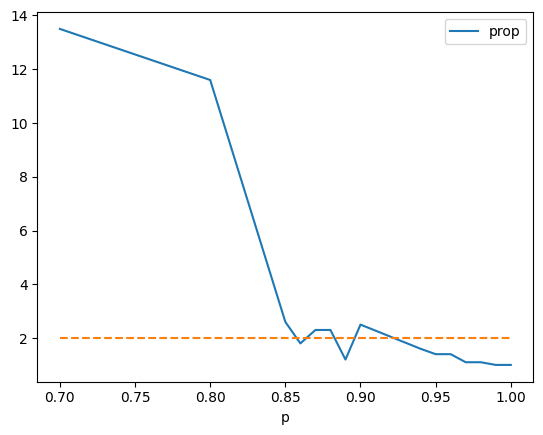

In [21]:
ax = df.plot(x="p", y="prop")
ax.plot([0.7, 1.0], [2, 2], "--");

Dans cette configuration, en supposant qu'un seul élève est contaminé, il faudrait vacciner à plus de 85% pour avoir une chance de ne pas avoir une nouvelle contamination.

Ce résultat ne change pas si la taille de la matrice change. Il change en revanche en fonction du nombre de tirages, ici 10. Pour n'avoir aucune propagation, il faut entourer la personne contaminé de 4 personnes vaccinées. $p$ est la probabilité pour une personné d'être vaccinée (ou immunisée si la vaccination est faite sur 100% des personnes). $p^4$ est la probabilité d'avoir 4 personnes vaccinées. $q=1-p^4$ est la probabilité qu'une personne ne soient pas immunisées parmi les 4. $1 - (1-q)^{10}$ est la probabilité que 10 cours de 3h se passent bien sans contamination.

In [22]:
p = 0.9
p4 = 1 - (1 - p) ** 4
p4

0.9999

In [23]:
df2 = df.copy()
df2["P4**100"] = 1 - df2["p"] ** 40

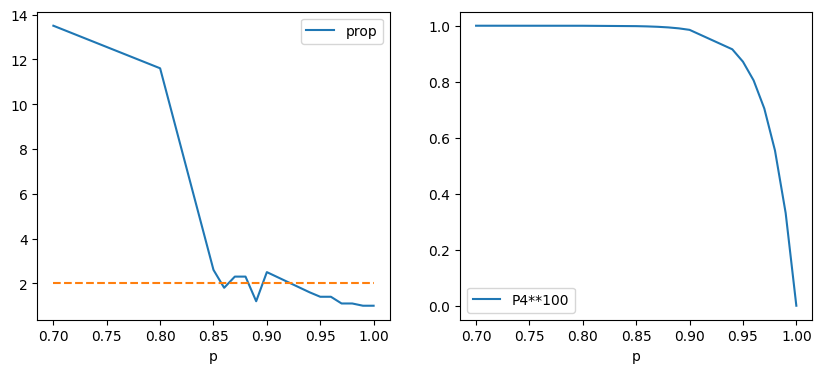

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
df2.plot(x="p", y="prop", ax=ax[0])
ax[0].plot([0.7, 1.0], [2, 2], "--")
df2.plot(x="p", y="P4**100", ax=ax[1]);